# Fine-tuning InceptionV3 for flowers classification

In this lecture we will fine-tune InceptionV3 architecture for flowers classification task.

InceptionV3 architecture (https://ai.googleblog.com/2016/08/improving-inception-and-image.html):
<img src="images/inceptionv3.png" style="width:70%">

Flowers classification dataset (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) consists of 102 flower categories commonly occurring in the United Kingdom. Each class contains between 40 and 258 images:
<img src="images/flowers.jpg" style="width:70%">

# Import modules

In [1]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
import cv2  # for image processing
from sklearn.model_selection import train_test_split
import scipy.io
import os
import tarfile
import tqdm
import utils
from utils import reset_tf_session
from utils import ModelSaveCallback
from utils import download_file

Using TensorFlow backend.


1.12.0
2.2.4


# Load dataset

Dataset was downloaded for you, it takes 12 min and 400mb.
Relevant links (just in case):
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

In [2]:
url = 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz'
filepath = '/Users/molinaro/.keras/datasets/102flowers.tgz'

download_file(url, filepath)

# Prepare images for model

In [3]:
# we will crop and resize input images to IMG_SIZE x IMG_SIZE
IMG_SIZE = 250

In [4]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

We will take a center crop from each image like this:
<img src="images/center_crop.jpg" style="width:50%">

In [5]:
def image_center_crop(img):
    """
    Makes a square center crop of an img, which is a [h, w, 3] numpy array.
    Returns [min(h, w), min(h, w), 3] output with same width and height.
    For cropping use numpy slicing.
    """
    
    import math as M
    h, w, _ = img.shape

    irow = int(M.ceil((h-w) / 2))

    icol = int(M.ceil((w-h) / 2))
    
    if h < w:
        cropped_img = img[:,icol:(w-icol),:]
    elif h > w: 
        cropped_img = img[irow:(h-irow),:,:]
    else:
        cropped_img = img[:,:,:]
    
    return cropped_img

In [6]:
def prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=True):
    img = decode_image_from_raw_bytes(raw_bytes)  # decode image raw bytes to matrix
    img = image_center_crop(img)  # take squared center crop
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # resize for our model
    if normalize_for_model:
        img = img.astype("float32")  # prepare for normalization
        img = keras.applications.inception_v3.preprocess_input(img)  # normalize for model
    return img

In [7]:
# reads bytes directly from tar by filename (slow, but ok for testing, takes ~6 sec)
def read_raw_from_tar(tar_fn, fn):
    with tarfile.open(tar_fn) as f:
        m = f.getmember(fn)
        return f.extractfile(m).read()

(500, 591, 3)


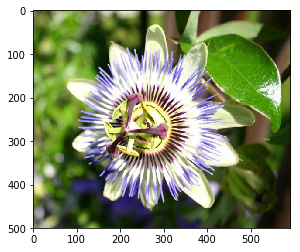

(250, 250, 3)


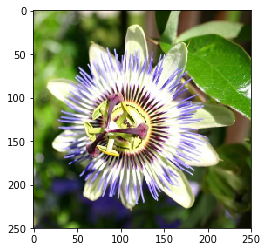

In [8]:
# test cropping
raw_bytes = read_raw_from_tar(filepath, "jpg/image_00001.jpg")

img = decode_image_from_raw_bytes(raw_bytes)
print(img.shape)
plt.imshow(img)
plt.show()

img = prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=False)
print(img.shape)
plt.imshow(img)
plt.show()

# Prepare for training

In [9]:
url2 = 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat'
filepath2 = '/Users/molinaro/.keras/datasets/imagelabels.mat'

download_file(url2, filepath2)

In [10]:
# read all filenames and labels for them

# read filenames firectly from tar
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

all_files = sorted(get_all_filenames(filepath))  # list all files in tar sorted by name
all_labels = scipy.io.loadmat(filepath2)['labels'][0] - 1  # read class labels (0, 1, 2, ...)
# all_files and all_labels are aligned now
N_CLASSES = len(np.unique(all_labels))
print(N_CLASSES)

102


In [11]:
# split into train/test
tr_files, te_files, tr_labels, te_labels = \
    train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

In [12]:
# will yield raw image bytes from tar with corresponding label
def raw_generator_with_label_from_tar(tar_fn, files, labels):
    label_by_fn = dict(zip(files, labels))
    with tarfile.open(tar_fn) as f:
        while True:
            m = f.next()
            if m is None:
                break
            if m.name in label_by_fn:
                yield f.extractfile(m).read(), label_by_fn[m.name]

In [13]:
# batch generator

def batch_generator(items, batch_size):
    """
    Implement batch generator that yields items in batches of size batch_size.
    There's no need to shuffle input items, just chop them into batches.
    Remember about the last batch that can be smaller than batch_size!
    Input: any iterable (list, generator, ...). 
        In case of generator you can pass through your items only once!
    Output: In output yield each batch as a list of items.
    """

    batch = []
    
    for item in items:
        batch.append(item)
        if len(batch) == batch_size:
            yield list(batch)
            batch = []
    if batch:
        yield list(batch)    

In [14]:
# Check the batch generator
#for x in batch_generator(range(10),3):
#    print(x)
#    for r  in x:
#        print(r)

In [15]:
BATCH_SIZE = 32

def train_generator(files, labels, batch_size):
    while True:  # so that Keras can loop through this as long as it wants
        for batch in batch_generator(raw_generator_with_label_from_tar(
                filepath, files, labels), batch_size):
            # prepare batch images
            batch_imgs = []
            batch_targets = []
            for raw, label in batch:
                img = prepare_raw_bytes_for_model(raw)
                batch_imgs.append(img)
                batch_targets.append(label)
            # stack images into 4D tensor [batch_size, img_size, img_size, 3]
            batch_imgs = np.stack(batch_imgs, axis=0)
            # convert targets into 2D tensor [batch_size, num_classes]
            batch_targets = keras.utils.np_utils.to_categorical(batch_targets, N_CLASSES)
            yield batch_imgs, batch_targets

(32, 250, 250, 3) (32, 102)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(32, 250, 250, 3) (32, 102)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


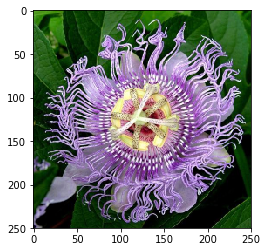

In [16]:
# test training generator
for _ in range(2):
    for _ in train_generator(tr_files, tr_labels, BATCH_SIZE):
        print(_[0].shape, _[1].shape)
        print(_[1])
        plt.imshow(np.clip(_[0][0] / 2. + 0.5, 0, 1))
        break

(20, 250, 250, 3) (20, 102)


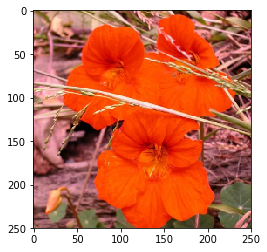

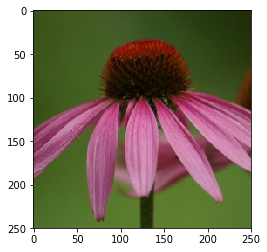

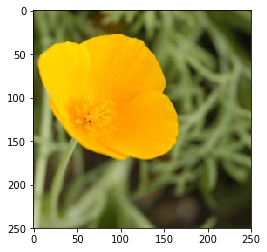

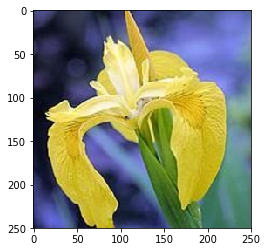

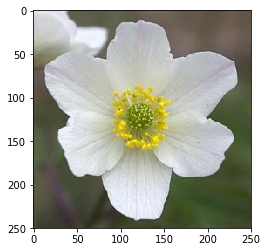

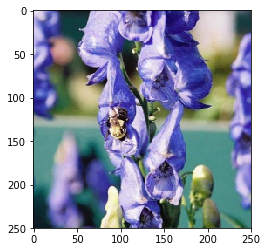

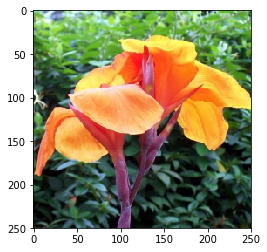

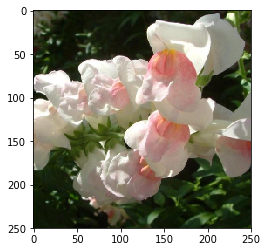

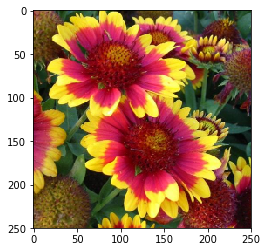

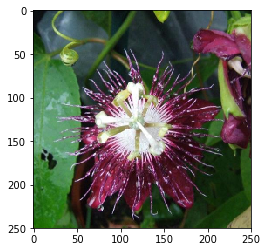

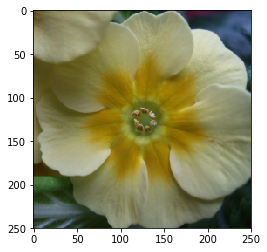

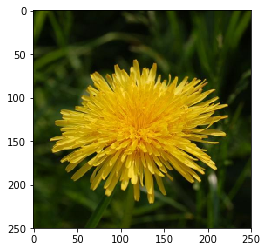

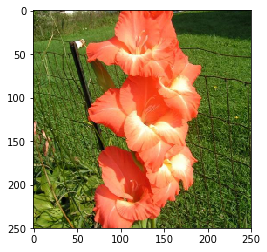

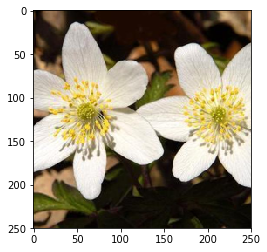

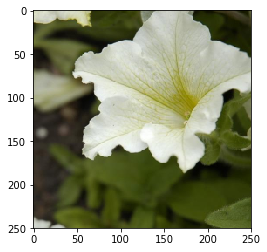

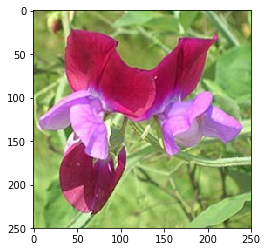

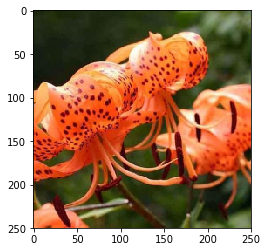

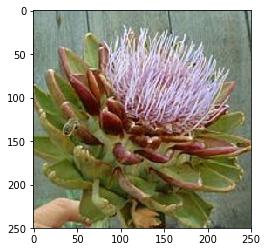

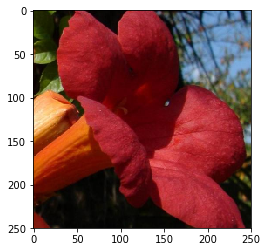

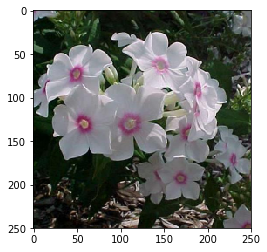

In [17]:
# test training generator

for _ in train_generator(te_files[0:20], te_labels[0:20], BATCH_SIZE):
        print(_[0].shape, _[1].shape)
        #print(_[1])
        for k in range(_[1].shape[0]): 
            plt.imshow(_[0][k]/ 2. + 0.5)
            plt.show()
        #plt.imshow(np.clip(_[0][k] / 2. + 0.5, 0, 1))
        break

# Training

We cannot train such a huge architecture from scratch with such a small dataset.

But using fine-tuning of last layers of pre-trained network we can get a pretty good classifier very quickly.

In [18]:
# remember to clear session if you start building graph from scratch!
s = reset_tf_session()
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)

In [19]:
def inception(use_imagenet=True):
    # load pre-trained model graph, don't add final layer
    model = keras.applications.InceptionV3(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                          weights='imagenet' if use_imagenet else None)
    # add global pooling just like in InceptionV3
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
    # add new dense layer for our labels
    new_output = keras.layers.Dense(N_CLASSES, activation='softmax')(new_output)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [20]:
model = inception()

In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 124, 124, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 124, 124, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [22]:
# number of layers of our model 
print(len(model.layers))

313


In [23]:
# set all layers trainable by default
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, keras.layers.BatchNormalization): 
        # we do aggressive exponential smoothing of batch norm 
        # parameters to faster adjust to our new dataset
        layer.momentum = 0.8   
        
# fix deep layers (fine-tuning only last 50)
for layer in model.layers[:-50]:
    layer.trainable = False

In [24]:
# compile new model
model.compile(
    loss='categorical_crossentropy',  # we train 102-way classification
    optimizer=keras.optimizers.adamax(lr=1e-2),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  # report accuracy during training
)

In [25]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = 'flowers.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch

# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 10
# model = load_model(model_filename.format(last_finished_epoch))

Training takes **2 hours**. You're aiming for ~0.93 validation accuracy.

In [28]:
# fine tune for 2 epochs (full passes through all training data)
# we make 2*8 epochs, where epoch is 1/8 of our training data to see progress more often

BATCH_SIZE = 32

model.fit_generator(
    train_generator(tr_files, tr_labels, BATCH_SIZE), 
    steps_per_epoch=len(tr_files) // BATCH_SIZE // 8,
    epochs=2 * 8,
    validation_data=train_generator(te_files, te_labels, BATCH_SIZE), 
    validation_steps=len(te_files) // BATCH_SIZE // 4,
    callbacks=[ModelSaveCallback(model_filename)],
    verbose=1,
    initial_epoch=last_finished_epoch or 0
)

Epoch 1/16
25/25 [==============================] - 102s 4s/step - loss: 1.1424 - acc: 0.7963 - val_loss: 4.5039 - val_acc: 0.1510
Model saved in flowers.000.hdf5
Epoch 2/16
25/25 [==============================] - 101s 4s/step - loss: 1.0278 - acc: 0.8050 - val_loss: 4.1041 - val_acc: 0.2396
Model saved in flowers.001.hdf5
Epoch 3/16
25/25 [==============================] - 103s 4s/step - loss: 0.7856 - acc: 0.8387 - val_loss: 3.7009 - val_acc: 0.3047
Model saved in flowers.002.hdf5
Epoch 4/16
25/25 [==============================] - 110s 4s/step - loss: 0.8582 - acc: 0.8113 - val_loss: 4.2454 - val_acc: 0.2839
Model saved in flowers.003.hdf5
Epoch 5/16
25/25 [==============================] - 102s 4s/step - loss: 0.6920 - acc: 0.8287 - val_loss: 3.7401 - val_acc: 0.2542
Model saved in flowers.004.hdf5
Epoch 6/16
25/25 [==============================] - 113s 5s/step - loss: 0.6553 - acc: 0.8362 - val_loss: 3.6454 - val_acc: 0.3698
Model saved in flowers.005.hdf5
Epoch 7/16
25/25 [====

In [30]:
# Accuracy on validation set
test_accuracy = model.evaluate_generator(
    train_generator(te_files, te_labels, BATCH_SIZE), 
    len(te_files) // BATCH_SIZE // 2)[1]

print(test_accuracy)

0.34375


That's it! Congratulations!

What you've done:
- prepared images for the model
- implemented your own batch generator
- fine-tuned the pre-trained model

In [31]:
batch_targets=[]
batch_imgs = []
dict_lab_files = dict(zip(te_files,te_labels))

with tarfile.open(filepath) as f:
    for m in f.getmembers():  # listing members is slow, but then it's fast!
        if m.name in te_files:
            raw = f.extractfile(m).read()
            img = prepare_raw_bytes_for_model(raw)
            batch_imgs.append(img)
            batch_targets.append(dict_lab_files[m.name])
            
# stack images into 4D tensor [batch_size, img_size, img_size, 3]
batch_imgs = np.stack(batch_imgs, axis=0)
predictions = np.argmax(model.predict(batch_imgs),axis=1)

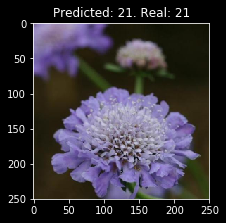

In [42]:
class_index = 21
number_images = 12

rows = number_images // 4
if number_images % 4 != 0: rows += 1
cols = 4
fig = plt.figure(figsize=(4 * cols - 1, 4 * rows - 1))
i=0
plt.style.use('dark_background')
for index in list(np.argwhere(predictions==class_index).flatten())[:number_images]:
    i+=1
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow((batch_imgs[index]+1)/2) #Try simply ax.imshow(batch_imgs[index]) if you have error
    ax.set_title('Predicted: '+str(predictions[index])+'. Real: '+str(batch_targets[index]))
plt.show()